In [63]:
#LSTM

import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
np.random.seed(7)



In [64]:
PULoc = 4

In [65]:
dataframe = pandas.read_csv('Demand_Data3_Train_CV_2017.csv', usecols=[4,3], engine='python', skipfooter=3)
dataframe = dataframe[dataframe['PULocationID'] == 4]
dataframe = dataframe['passenger_count']
dataset = dataframe.values
dataset = dataset.astype('float32')
dataset = dataset[0:24*100]
dataset = np.reshape(dataset, (len(dataset),1))
print(dataset)

[[135.]
 [144.]
 [190.]
 ...
 [ 17.]
 [ 25.]
 [  9.]]


In [66]:
Test = pandas.read_csv('Demand_Data3_Test_Predictions_2017.csv', usecols=[4,3], engine='python', skipfooter=3)
Test = Test[Test['PULocationID'] == 4]
Test = Test['passenger_count']
Test_Values = Test.values
Test_Values = Test_Values.astype('float32')
Test_Values = Test_Values[0:24*100]
Test_Values = np.reshape(Test_Values, (len(Test_Values),1))
print(Test_Values)

[[70.]
 [28.]
 [23.]
 ...
 [69.]
 [65.]
 [58.]]


In [67]:
#Preprocessing Trainng
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


In [68]:
#Training/Testing Data (Train on Jan-Oct, Ttest on Nov-Dec)
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train = dataset[0:train_size,:]
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
#train_size = len(dataset)
#test_size = len(Test_Values)
#train = dataset
#test = Test_Values

In [69]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [70]:

# create and fit the LSTM network
model = Sequential()
#model.add(LSTM(1, input_shape=(1, look_back)))
model.add(LSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=10, verbose=2)



Epoch 1/10
 - 1s - loss: 0.0214
Epoch 2/10
 - 0s - loss: 0.0132
Epoch 3/10
 - 0s - loss: 0.0107
Epoch 4/10
 - 0s - loss: 0.0081
Epoch 5/10
 - 0s - loss: 0.0060
Epoch 6/10
 - 0s - loss: 0.0048
Epoch 7/10
 - 0s - loss: 0.0044
Epoch 8/10
 - 0s - loss: 0.0042
Epoch 9/10
 - 0s - loss: 0.0042
Epoch 10/10
 - 0s - loss: 0.0042


In [71]:

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
 #invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))




Train Score: 15.48 RMSE
Test Score: 15.70 RMSE


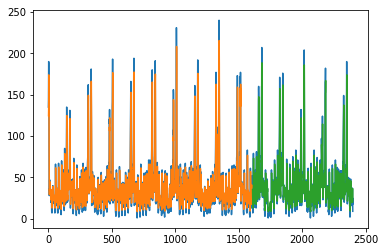

In [72]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)